## 1. Import libraries and split dataset into training and test sets

Download [`brain-mri-images` dataset from kaggle](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

Credits: [@hackspyder](https://www.kaggle.com/hackspyder/brain-mri-with-convolutional-autoencoder)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import matplotlib.pyplot as plt
import glob
import numpy as np 
import pandas as pd
import tensorflow as tf
import cv2
import imutils

dir_path = 'brain-mri-images'

def load_images(category_type):
    src_path = glob.glob(f'{dir_path}/{category_type}/*.jpg')
    arr = np.zeros((len(src_path), 258, 540, 1))

    for i, file_name in enumerate(src_path):
        img = image.load_img(file_name, color_mode='grayscale', target_size=(258, 540))
        arr[i] = image.img_to_array(img).astype('float32') / 255.0
    
    return arr

yes_dataset = load_images('yes')
no_dataset = load_images('no')

x_train, x_valid, y_train, y_valid = train_test_split(yes_dataset, yes_dataset, test_size=0.2, random_state=42)
# To be compared against later after the whole process.
x_test = no_dataset

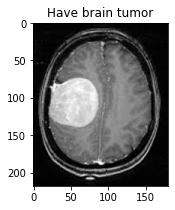

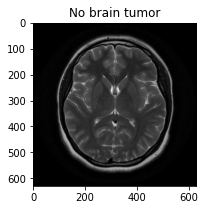

In [38]:
# Display a sample to understand the data for brain tumor ("yes")
plt.figure(figsize=(8,3))
plt.title('Have brain tumor')
plt.imshow(cv2.imread(f'{dir_path}/yes/Y1.jpg', 0), cmap='gray')

# Display a sample to understand the data for brain tumor ("no")
plt.figure(figsize=(8,3))
plt.title('No brain tumor')
plt.imshow(cv2.imread(f'{dir_path}/no/1 no.jpeg', 0), cmap='gray')

## 2. Create the Autoencoder model

<img src="https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png" width="450" height="auto" />

(Source: [Deepak Birla, 2019](https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f))

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" width="400" height="auto" />

(Source: [Francois Chollet, 2016](https://blog.keras.io/building-autoencoders-in-keras.html))

Represented in ANN way,

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png" width="450" height="auto" />

(Source: [JEREMY JORDAN, 2018](https://www.jeremyjordan.me/autoencoders/))

In [39]:
# Input image layer. (rows, cols, channels)
input_layer = Input(shape=(258, 540, 1))

# Encoder
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
        
# Decoder
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)

# Output image layer
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

model = Model(input_layer, output_layer)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

## 3. Train the Autoencoder model

Read [here for more details on early stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

In [40]:
# Stops training the moment the loss starts to increase after a decreasing trend
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
history = model.fit(x_train, y_train, batch_size=80,
                                      epochs=25,
                                      validation_data=(x_valid, y_valid),
                                      callbacks=[early_stopping])

Epoch 1/25
1/1 [==============================] - 115s 115s/step - loss: 0.1172 - val_loss: 0.1107
Epoch 2/25
1/1 [==============================] - 98s 98s/step - loss: 0.1140 - val_loss: 0.1105
Epoch 3/25
1/1 [==============================] - 93s 93s/step - loss: 0.1121 - val_loss: 0.1108
Epoch 4/25
1/1 [==============================] - 97s 97s/step - loss: 0.1106 - val_loss: 0.1114
Epoch 5/25
1/1 [==============================] - 101s 101s/step - loss: 0.1095 - val_loss: 0.1113
Epoch 6/25
1/1 [==============================] - 101s 101s/step - loss: 0.1082 - val_loss: 0.1102
Epoch 7/25
1/1 [==============================] - 95s 95s/step - loss: 0.1064 - val_loss: 0.1083
Epoch 8/25
1/1 [==============================] - 96s 96s/step - loss: 0.1042 - val_loss: 0.1054
Epoch 9/25
1/1 [==============================] - 100s 100s/step - loss: 0.1014 - val_loss: 0.1020
Epoch 10/25
1/1 [==============================] - 109s 109s/step - loss: 0.0983 - val_loss: 0.0979
Epoch 11/25
1/1 [==

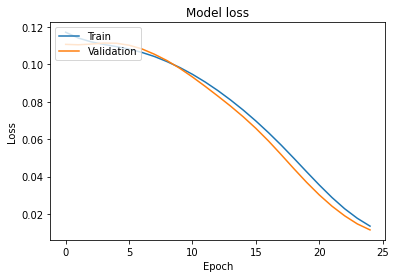

In [43]:
# Plot against the model loss errors
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 4. Start predictions based on learned features

If they are encoded again through the encoder and then passed to the decoder, how would the reconstructed image looks like?

[Read here for more info](https://blog.keras.io/building-autoencoders-in-keras.html)

In [80]:
preds = model.predict(x_test)

In [81]:
def display_plt(data, cmap):
    data_shp = data * 255.0
    plt.imshow(data_shp.reshape(258, 540), cmap=cmap)

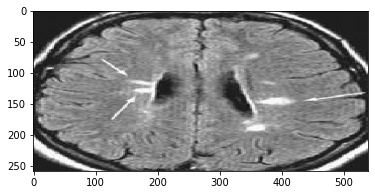

In [82]:
display_plt(x_test[0], cmap='gray')

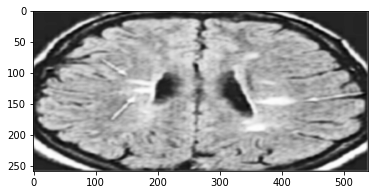

In [83]:
display_plt(preds[0], cmap='gray')

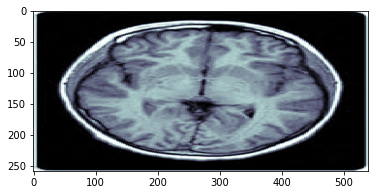

In [84]:
display_plt(x_test[10], cmap='bone')

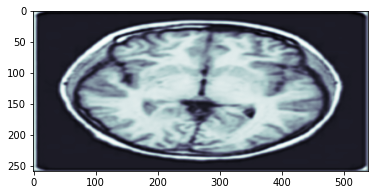

In [85]:
display_plt(preds[10], cmap='bone')

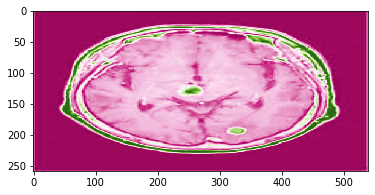

In [86]:
display_plt(x_test[20], cmap='PiYG')

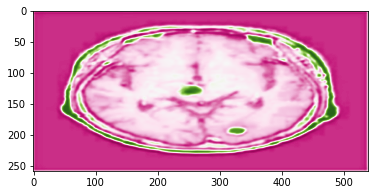

In [87]:
display_plt(preds[20], cmap='PiYG')

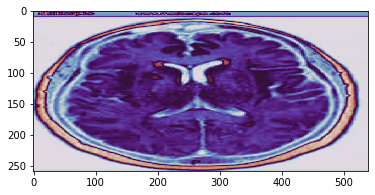

In [88]:
display_plt(x_test[50], cmap='twilight')

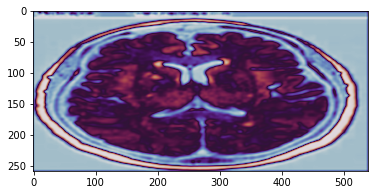

In [89]:
display_plt(preds[50], cmap='twilight')